# <span style="color:green"><center>Diplomado en Inteligencia Artificial y Aprendizaje Profundo</center></span>

# <span style="color:red"><center>Autoencoders: Ejemplo LFW</center></span>

##   <span style="color:blue">Profesores</span>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Campo Elías Pardo Turriago, cepardot@unal.edu.co 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Asistentes</span>

5. Oleg Jarma, ojarmam@unal.edu.co 
6. Laura Lizarazo, ljlizarazore@unal.edu.co 

## <span style="color:blue">Contenido</span> 

* [Introducción](#Introducción)
* [Autocodificador o autoencoder](#Autocodificador-o-autoencoder)
* [Importa módulos](#Importa-módulos)
* [Parámetros de la red](#Parámetros-de-la-red)
* [Codificador](#Codificador)
* [Decodificador](#Decodificador)
* [Auto-codificador](#Auto-codificador)
* [Entrenamiento](#Compila)
* [Recuperación de imágenes](#Recuperación-de-imágenes)
* [Representación latente](#Representación-latente)

## <span style="color:blue">Introducción</span>

En este cuaderno se implementa un Autoencoder  para la recosntrucción de rostros conjunto de datos [LFW](http://vis-www.cs.umass.edu/lfw/) (**Labeled Faces in the Wild**). 

Basado en [Autoencoders for Image Reconstruction in Python and Keras](https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/)

- [Deep Aligned paper](http://vis-www.cs.umass.edu/papers/nips2012_deep_congealing.pdf)

## <span style="color:blue">Importar y procesar imágenes</span>

In [1]:
#importar open cv                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ii!conda install -c conda-forge opencv
import cv2
#importar pandas para manejo de dataframes
import pandas as pd
# import tarfile para manejo de archivos comprimidos
import tarfile
# Barra de progreso
from tqdm.notebook import tqdm
# Manejo de archivos del computador
import os
# Manejo de gráficos
import matplotlib.pyplot as plt
# Manejo de Arreglos
import numpy as np

In [2]:
# Metadata de los datos y algunas características
# http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
ATTRS_NAME = "../Data/lfw_attributes.txt"

# Imágenes usando DeepFunneled (Menos Espacio)
# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
IMAGES_NAME = "../Data/lfw-deepfunneled.tgz"

# Imágenes completas
# http://vis-www.cs.umass.edu/lfw/lfw.tgz
RAW_IMAGES_NAME = "../Data/lfw.tgz"

Se construyen funciones para leer y preprocesar los datos usando OpenCV

In [3]:
## Función  para decodificar las imágenes bajadas desde datos crudos (bytes)
def decode_image_from_raw_bytes(raw_bytes):
    # Decodificar desde archivos crudos en formato adecuado, flag =1 significa leer en BGR
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    #Convertir a RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

Procesamiento individual

In [4]:
indice=2
#indice=slice(3)

with tarfile.open(RAW_IMAGES_NAME) as f:
    m=f.getmembers()[indice]
    print(m)
    img=decode_image_from_raw_bytes(f.extractfile(m).read())
    print(img.shape)

<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0001.jpg' at 0x7feb4c571040>
(250, 250, 3)


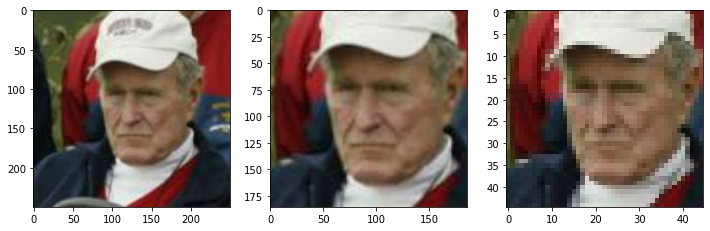

In [5]:
plt.figure(figsize=(12,5))

plt.subplot(131)
plt.imshow(img)

dx=32
dy=32
img_new=img[dx:-dx,dy:-dy]
plt.subplot(132)
plt.imshow(img_new)

dimx=45
dimy=45

img_new=cv2.resize(img_new, (dimx, dimy))
plt.subplot(133)
plt.imshow(img_new)

plt.show()

In [6]:
### Función para bajar las imagenes del .tgz y preprocesarlas sistemáticamente
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Leer archivo lfw_attributes.txt y hacer una limpieza inicial
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    # Corrimiento de carácteres incorrectos
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    # Filtrar nombres de personas y numeros de imagen (por persona), convertir a conjunto
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Leer Fotos e identificación
    all_photos = []
    photo_ids = []

    # Abrir archivo .tgz sin descomprimir
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        # tqdm se usa para mostrar la barra de progreso
        for m in tqdm(f.getmembers()):
            # Solo procesa los archivos desde el archivo comprimido que sean realmente imágenes (.jpg)
            if m.isfile() and m.name.endswith(".jpg"):
                # Descomprimir archivo desde el comprimido y convertir a RGB
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Recortar lo que sean caras y cambiar tamaño
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Obtener nombre de la persona y agregarlo a la colección de datos
                fname = os.path.split(m.name)[-1]
                # La razón de -4 es para quitar la extensión .jpg
                fname_splitted = fname[:-4].replace('_', ' ').split()
                # Sacar la identificación del nombre
                person_id = ' '.join(fname_splitted[:-1])
                # Sacar el número de foto por separado
                photo_number = int(fname_splitted[-1])
                # Comparar los metadatos con las fotos reales (DEBEN COINCIDIR)
                if (person_id, photo_number) in imgs_with_attrs:
                    # Cuando coinciden, agregar las fotos
                    all_photos.append(img)
                    # Y también agregar la identidad de las personas
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})
                    
    # Hacer un dataframe con los resultados
    photo_ids = pd.DataFrame(photo_ids)
    # UNir las imágenes en un tensor 4D
    all_photos = np.stack(all_photos).astype('uint8')

    # Preservar el orden de encontrados en búsqueda
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs, photo_ids

In [7]:
# Obtener el conjunto de datos sin descomprimir
dim_x=50
dim_y=50
X, attr,names = load_lfw_dataset(use_raw=True, dimx=dim_x, dimy=dim_y)

  0%|          | 0/18983 [00:00<?, ?it/s]

In [8]:
X.shape

(13143, 50, 50, 3)

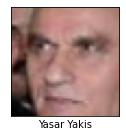

In [9]:
azar=np.random.randint(len(X))

plt.figure(figsize=(2,2))
plt.imshow(X[azar])
plt.xticks([])
plt.yticks([])
plt.xlabel(names.person[azar])
plt.show()

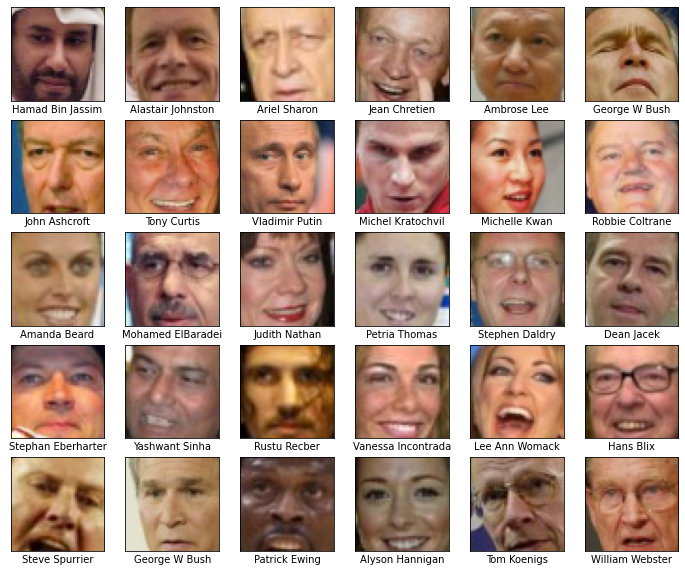

In [10]:
plt.figure(figsize=(12,10))

numero_muestras=30

muestra=np.random.randint(0,len(X),numero_muestras)

for i in range(numero_muestras):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[muestra[i]])
    plt.xlabel(names.person[muestra[i]])

plt.show()

In [11]:
X = X.astype('float32') / 255.0
X = X - 0.5

## <span style="color:blue">Importa módulos</span>



In [12]:
# Importar tensorflow
import tensorflow as tf
# importar layers apropiados para la Red
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Reshape
from tensorflow.keras.models import Model
# Graficar modelo
from tensorflow.keras.utils import plot_model
# Importar optimizadores
from tensorflow.keras.optimizers import Adam, Adamax
# Importar Función de Pérdida
from tensorflow.keras.losses import MeanSquaredError
# Función parar separar datos de entrenamiento y validación
from sklearn.model_selection import train_test_split
# Dibujos
import matplotlib.pyplot as plt

## <span style="color:blue">Parámetros de la red Codificadora</span>


In [13]:
input_shape = X.shape[1:] # (ancho, alto, canales)
intermediate_dim_1 = 1024
intermediate_dim_2 = 64
intermediate_dim_3 = 32
intermediate_dim_4 = 16
latent_dim = 1000
    
# Train parameters
epochs = 20
batch_size = 64

## <span style="color:blue">Codificador: encoder</span>


Model: "Codificador_Denso"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Entrada_Codif (InputLayer)   [(None, 50, 50, 3)]       0         
_________________________________________________________________
Aplanar_Datos (Flatten)      (None, 7500)              0         
_________________________________________________________________
Espacio_Latente_1000 (Dense) (None, 1000)              7501000   
Total params: 7,501,000
Trainable params: 7,501,000
Non-trainable params: 0
_________________________________________________________________


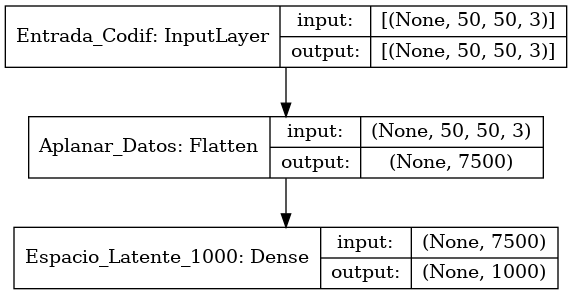

In [14]:
# Define encoder model
inputs = Input(shape=input_shape,name='Entrada_Codif')
x = Flatten(name='Aplanar_Datos')(inputs)
#x = Activation('relu',name='Relu')(x)
#x = Dense(intermediate_dim_1, name='Capa_Oculta_{}'.format(intermediate_dim_1))(x)
#x = Activation('relu',name='Relu_2')(x)
#x = Dense(intermediate_dim_2, name='hidden_layer_2_e')(x)
#x = Activation('relu')(x)
#x = Dense(intermediate_dim_3, name='hidden_layer_3_e')(x)
#x = Activation('relu')(x)
#x = Dense(intermediate_dim_4, name='hidden_layer_4_e')(x)
#x = Activation('relu')(x)
outputs = Dense(latent_dim, name='Espacio_Latente_{}'.format(latent_dim))(x)
#outputs = LayerNormalization(axis=1)(x)

encoder = Model(inputs=inputs, outputs=outputs, name='Codificador_Denso')

encoder.summary()
plot_model(encoder, to_file='../Imagenes_Model/encoder_dense_lfw.png', show_shapes=True)

## <span style="color:blue">Decodificador: decoder</span>


Model: "Decodificador_Denso"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Entrada_Deco_1000 (InputLaye [(None, 1000)]            0         
_________________________________________________________________
Dimension_Inicial (Dense)    (None, 7500)              7507500   
_________________________________________________________________
Devolver_Forma (Reshape)     (None, 50, 50, 3)         0         
Total params: 7,507,500
Trainable params: 7,507,500
Non-trainable params: 0
_________________________________________________________________


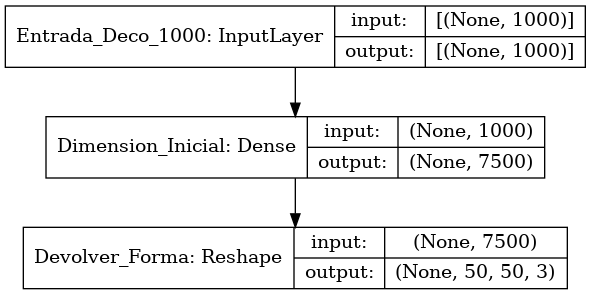

In [15]:
# Define decoder model
latent_input = Input(shape = (latent_dim,), name='Entrada_Deco_{}'.format(latent_dim))
#x = Activation('relu',name='Relu_2')(latent_input)
#x = Dense(intermediate_dim_4 , name='hidden_layer_de_4_d')(latent_input)
#x = Activation('relu')(x)
#x = Dense(intermediate_dim_3 , name='hidden_layer_de_3_d')(x)
#x = Activation('relu')(x)
#x = Dense(intermediate_dim_2 , name='hidden_layer_de_2_d')(x)
#x = Activation('relu')(x)
#x = Dense(intermediate_dim_1 , name='Capa_Oculta_{}'.format(intermediate_dim_1))(latent_input)
#x = Activation('relu',name='Relu')(x)
x = Dense(np.prod(input_shape) , name='Dimension_Inicial')(latent_input)
x = Reshape(input_shape,name='Devolver_Forma')(x)

decoder = Model (inputs=latent_input, outputs=x, name='Decodificador_Denso')

decoder.summary()

plot_model(decoder, to_file='../Imagenes_Model/decoder_dense_lfw.png', show_shapes=True)

## <span style="color:blue">Auto-codificador: auto-encoder</span>


Model: "autoencoder_lfw_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Entrada_Codif (InputLayer)   [(None, 50, 50, 3)]       0         
_________________________________________________________________
Codificador_Denso (Functiona (None, 1000)              7501000   
_________________________________________________________________
Decodificador_Denso (Functio (None, 50, 50, 3)         7507500   
Total params: 15,008,500
Trainable params: 15,008,500
Non-trainable params: 0
_________________________________________________________________


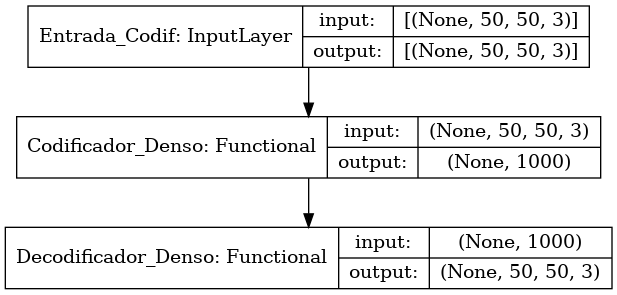

In [16]:
# Autoencoder Model
autoencoder = Model(inputs=inputs, 
                    outputs=decoder(encoder(inputs)),
                    name='autoencoder_lfw_model')

#Summary
autoencoder.summary()
plot_model(autoencoder, to_file='../Imagenes_Model/autoencoder_dense_lfw.png',show_shapes=True)

## <span style="color:blue">Entrenamiento</span>

### Compila

In [17]:
# Usaremos el optimizador Adamax (Pruebe otros y note diferencias)
optimizer = Adamax(learning_rate=1e-3)
# Se usará el error cuadrático medio
loss_fn = MeanSquaredError()
# Compilar autoencoder
autoencoder.compile(optimizer= optimizer, loss = loss_fn)

### Separar Datos

In [18]:
# Separar datos en entrenamiento y validación interna
X_train,X_test=train_test_split(X,test_size=0.1, random_state=42)

### Epochs

In [19]:
# Entrenar Modelo
history = autoencoder.fit(x=X_train, y=X_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/20
167/167 [==============================] - 37s 217ms/step - loss: 0.0240 - val_loss: 0.0082
Epoch 2/20
167/167 [==============================] - 37s 220ms/step - loss: 0.0075 - val_loss: 0.0059
Epoch 3/20
167/167 [==============================] - 30s 183ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 4/20
167/167 [==============================] - 31s 185ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
167/167 [==============================] - 31s 188ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 6/20
167/167 [==============================] - 31s 185ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 7/20
167/167 [==============================] - 32s 189ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/20
167/167 [==============================] - 32s 190ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 9/20
167/167 [==============================] - 31s 189ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 10/20
167/167 [==============================] - 31s 188ms/step - l

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch 
hist.tail()

,loss,val_loss,epoch
15,0.001345,0.001464,15
16,0.001269,0.001273,16
17,0.001185,0.001247,17
18,0.001114,0.001243,18
19,0.001064,0.001163,19


### Pérdida

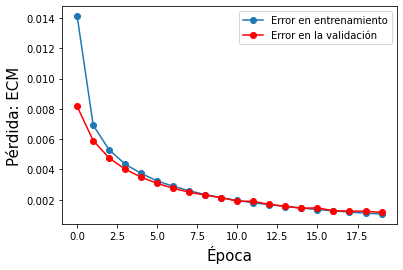

In [21]:
plt.figure()
plt.xlabel('Época',fontsize=15)
plt.ylabel('Pérdida: ECM',fontsize=15)
plt.plot(history.epoch, hist['loss'],'o-',label='Error en entrenamiento')
plt.plot(hist['epoch'], hist['val_loss'],'-ro',label='Error en la validación')
plt.legend()
plt.show()

## <span style="color:blue">Evaluación externa</span>


In [22]:
# External evaluation
autoencoder.evaluate(X_train,X_train) # 0.0043
autoencoder.evaluate(X_test,X_test) # 0.0056

42/42 [==============================] - 1s 34ms/step - loss: 0.0012


0.0011758251348510385

## <span style="color:blue">Recuperación de imágenes</span>


In [23]:
def reconstruction_image(img_original, img_decoded, image_size=32, num_images=8, random=True, file_name=None):
    
    # control number of images, maximum is  16. 
    if num_images > 16:
        num_images = 16
    
    # select images
    if random:
        shape_0 = img_original.shape[0]
        index = np.random.randint(low=0, high=shape_0, size=num_images)
    else:
        index = range(num_images) # first images
    
    # prepare data
    imgs = np.concatenate([img_original[index], img_decoded[index]])
    imgs = imgs.reshape((2, num_images, image_size, image_size,3))
    imgs = np.vstack([np.hstack(i) for i in imgs])
    
    # plot
    plt.figure(figsize=(22,22))
    plt.axis('off')
    plt.title('Entrada: Primera Fila, Decodificado: Segunda fila')
    plt.imshow(np.clip(imgs+0.5,0,1))
    if file_name is not None:
        plt.savefig(file_name)
    plt.show()

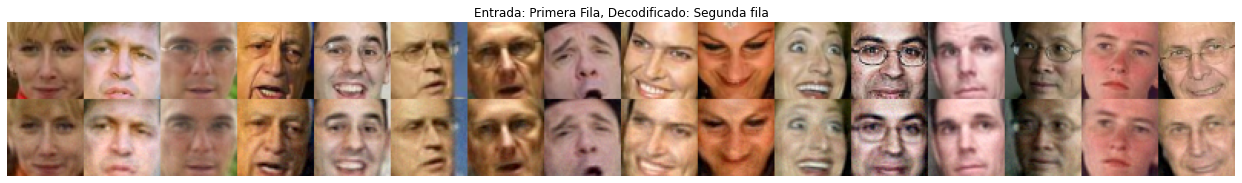

In [24]:
file_name = '../Output/Entrada_y_Recuperacion.png'
reconstruction_image(img_original= X_test, img_decoded=autoencoder.predict(X_test), 
                         image_size=dim_x, num_images= 16, random=True,
                         file_name=file_name)

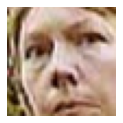

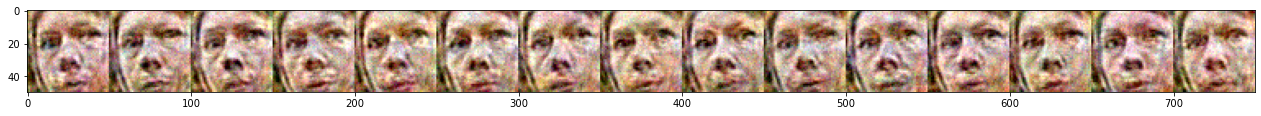

In [78]:
fotos=[]
azar=np.random.randint(len(X_test))
num_images=8

for i in range(15):
    code=encoder(X_test[azar].reshape(1,dim_x,dim_y,3))
    code_variation=code+np.random.normal(0,0.2,latent_dim)
    decode=decoder(code_variation)
    fotos.append(decode)

#imgs = imgs.reshape((2, num_images, 50, 50,3))
imgs = np.hstack([np.hstack(i) for i in fotos])

# plot
plt.figure(figsize=(2,2))
plt.axis('off')
#plt.title('Entrada: Primera Fila, Decodificado: Segunda fila')
plt.imshow((np.clip(X_test[azar]+0.5,0,1)))
plt.show()

plt.figure(figsize=(22,22))
plt.imshow(np.clip(imgs+0.5,0,1))
plt.show()

## <span style="color:blue">Representación latente</span>

### Imagen Generada por la función plot2D

![](../Imagenes/latent_2D_space_minist.png)